# Установка библиотеки ultralytics

In [1]:
# разкоментировать при первом запуске
#!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 882.7/882.7 kB 31.3 MB/s eta 0:00:00


# Импорты библиотек

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from PIL import Image
import shutil
import torch
from ultralytics import YOLO

# Загружаем датасет и фиксим в нем разметку

In [73]:
df = pd.read_csv("/kaggle/input/sila-dataset/defects.csv", delimiter =";")

# фикс разметки и удаление строк без класса
df.rename(columns={'length': 'width', 'width': 'length'}, inplace=True)
df['y_left_bottom'] = df.apply(lambda row: row['y_left_bottom'] - row['length'], axis=1)
df = df.dropna(subset=['main_class'])

df.head()

,main_class,additional_class,filename,x_left_bottom,y_left_bottom,width,length
0,царапины,Царапина на задней панели,2023-12-26 15-38-08.jpg,965,1670,637,1405
1,царапины,Царапина на задней панели,2024-01-15 13-40-28.jpg,885,1717,345,270
2,царапины,Царапина на задней панели,2024-01-15 13-42-01.jpg,989,2115,291,549
3,царапины,Царапина на задней панели,2024-01-15 13-50-51.jpg,1497,2308,345,489
4,царапины,Царапина на задней панели,2024-01-15 14-34-26.jpg,1145,2255,403,589


# Добавляем название и класс без дефектов к картинкам которые не были размечены

In [74]:
list_of_defects = list(df["filename"])
folder_path = '/kaggle/input/sila-dataset/data'
all_files = os.listdir(folder_path)
new_files = [file for file in all_files if file not in list_of_defects]


new_files_df = pd.DataFrame({'filename': new_files})


df = pd.concat([df, new_files_df], ignore_index=True)

df["main_class"].fillna('без дефектов', inplace=True)
df

,main_class,additional_class,filename,x_left_bottom,y_left_bottom,width,length
0,царапины,Царапина на задней панели,2023-12-26 15-38-08.jpg,965.0,1670.0,637.0,1405.0
1,царапины,Царапина на задней панели,2024-01-15 13-40-28.jpg,885.0,1717.0,345.0,270.0
2,царапины,Царапина на задней панели,2024-01-15 13-42-01.jpg,989.0,2115.0,291.0,549.0
3,царапины,Царапина на задней панели,2024-01-15 13-50-51.jpg,1497.0,2308.0,345.0,489.0
4,царапины,Царапина на задней панели,2024-01-15 14-34-26.jpg,1145.0,2255.0,403.0,589.0
...,...,...,...,...,...,...,...
196,без дефектов,NaN,2024-01-15 17-37-46.jpg,NaN,NaN,NaN,NaN
197,без дефектов,NaN,2024-01-15 14-55-37.jpg,NaN,NaN,NaN,NaN
198,без дефектов,NaN,20240219_╨б223093638.jpg,NaN,NaN,NaN,NaN
199,без дефектов,NaN,2024-01-15 18-50-29.jpg,NaN,NaN,NaN,NaN


# Итак здесь раскидываем по папкам и делаем аугментацию данных и кроп а так же создаем аннотации к картинкам

In [52]:
image_folder = '/kaggle/input/sila-dataset/data'
annotations_base_folder = '/kaggle/working/annotations_10'
images_base_folder = '/kaggle/working/images'
os.makedirs(annotations_base_folder, exist_ok=True)
os.makedirs(images_base_folder, exist_ok=True)

In [53]:
class_mapping = {
    'царапины': 0,
    'битые пиксели': 1,
    'проблемы с клавишами': 2,
    'замок': 3,
    'отсутствует шуруп': 4,
    'сколы': 5,
    'без дефектов': 6
}

In [54]:
for index, row in df.iterrows():
    filename = row['filename']
    x_left_bottom = row['x_left_bottom']
    y_left_bottom = row['y_left_bottom']
    width = row['width']
    length = row['length']

    image_path = os.path.join(image_folder, filename)
    main_class = row['main_class']

    class_image_folder = os.path.join(images_base_folder, main_class)
    class_annotation_folder = os.path.join(annotations_base_folder, main_class)
    os.makedirs(class_image_folder, exist_ok=True)
    os.makedirs(class_annotation_folder, exist_ok=True)

    saved_image_path = os.path.join(class_image_folder, filename)
    annotation_path = os.path.join(class_annotation_folder, filename[:-4] + ".txt")
    
    if os.path.exists(image_path):
        Image.open(image_path).save(saved_image_path)
        
        with open(annotation_path, 'w') as f:
            if pd.isna(x_left_bottom) or pd.isna(y_left_bottom) or pd.isna(width) or pd.isna(length):
                f.write(f"{class_mapping[main_class]}\n")
            else:
                with Image.open(image_path) as img:
                    image_width, image_height = img.size

                x_center = (x_left_bottom + (width / 2)) / image_width
                y_center = (y_left_bottom + (length / 2)) / image_height
                norm_width = width / image_width
                norm_height = length / image_height

                f.write(f"{class_mapping[main_class]} {x_center} {y_center} {norm_width} {norm_height}\n")
    else:
        print(f"файла нет: {image_path}")

shutil.make_archive(annotations_base_folder, 'zip', annotations_base_folder)

shutil.make_archive(images_base_folder, 'zip', images_base_folder)

файла нет: /kaggle/input/sila-dataset/data/20240219_С223093638.jpg


'/kaggle/working/images.zip'

# Обучение ёлы

In [63]:
data_yaml_path = '/kaggle/input/sila-dataset/data.yaml' 
epochs = 10 
img_size = 1080
batch = 8

In [64]:
model = YOLO('/kaggle/input/sila-dataset/yolo11n.pt') 

In [65]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [66]:
results = model.train(data=data_yaml_path, epochs=epochs, imgsz=img_size, batch=batch)  

engine/trainer: task=detect, mode=train, model=/kaggle/input/sila-dataset/yolo11n.pt, data=/kaggle/input/sila-dataset/data.yaml, epochs=10, time=None, patience=100, batch=8, imgsz=1080, save=True, save_period=-1, cache=False, device=cuda:0, workers=8, project=None, name=train6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript

train: Scanning /kaggle/input/sila-dataset/train/labels/broken_pixels... 130 images, 6 backgrounds, 76 corrupt: 100%|██████████| 136/136 [00:00<00:00, 187.45it/s]

train: WARNING ⚠️ /kaggle/input/sila-dataset/train/images/no_defects/2024-01-15 16-57-56.jpg: ignoring corrupt image/label: labels require 5 columns, 1 columns detected
train: WARNING ⚠️ /kaggle/input/sila-dataset/train/images/no_defects/2024-01-15 16-59-47.jpg: ignoring corrupt image/label: labels require 5 columns, 1 columns detected
train: WARNING ⚠️ /kaggle/input/sila-dataset/train/images/no_defects/2024-01-15 17-23-16.jpg: ignoring corrupt image/label: labels require 5 columns, 1 columns detected
train: WARNING ⚠️ /kaggle/input/sila-dataset/train/images/no_defects/2024-01-15 17-24-33.jpg: ignoring corrupt image/label: labels require 5 columns, 1 columns detected
train: WARNING ⚠️ /kaggle/input/sila-dataset/train/images/no_defects/2024-01-15 17-29-51.jpg: ignoring corrupt image/label: labels require 5 columns, 1 columns detected
train: WARNING ⚠️ /kaggle/input/sila-dataset/train/images/no_defects/2024-01-15 17-37-46.jpg: ignoring corrupt image/label: labels require 5 columns, 1 col

train: WARNING ⚠️ Cache directory /kaggle/input/sila-dataset/train/labels is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/input/sila-dataset/val/labels/broken_pixels... 52 images, 12 backgrounds, 22 corrupt: 100%|██████████| 64/64 [00:00<00:00, 217.41it/s]

val: WARNING ⚠️ /kaggle/input/sila-dataset/val/images/no_defects/2023-12-26 15-16-46.jpg: ignoring corrupt image/label: labels require 5 columns, 1 columns detected
val: WARNING ⚠️ /kaggle/input/sila-dataset/val/images/no_defects/2024-01-15 13-47-36.jpg: ignoring corrupt image/label: labels require 5 columns, 1 columns detected
val: WARNING ⚠️ /kaggle/input/sila-dataset/val/images/no_defects/2024-01-15 13-53-15.jpg: ignoring corrupt image/label: labels require 5 columns, 1 columns detected
val: WARNING ⚠️ /kaggle/input/sila-dataset/val/images/no_defects/2024-01-15 14-28-16.jpg: ignoring corrupt image/label: labels require 5 columns, 1 columns detected
val: WARNING ⚠️ /kaggle/input/sila-dataset/val/images/no_defects/2024-01-15 14-31-06.jpg: ignoring corrupt image/label: labels require 5 columns, 1 columns detected
val: WARNING ⚠️ /kaggle/input/sila-dataset/val/images/no_defects/2024-01-15 14-50-17.jpg: ignoring corrupt image/label: labels require 5 columns, 1 columns detected
val: WARNI

Plotting labels to runs/detect/train6/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1088 train, 1088 val
Using 4 dataloader workers
Logging results to runs/detect/train6
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      4.19G      3.672      22.21      2.935          4       1088: 100%|██████████| 8/8 [00:04<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.72it/s]

                   all         42         30          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      3.91G      3.637      20.73      2.996          3       1088: 100%|██████████| 8/8 [00:02<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.27it/s]

                   all         42         30   2.44e-05     0.0278   1.62e-05   1.62e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      3.91G      3.321      17.65      2.743          4       1088: 100%|██████████| 8/8 [00:02<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.94it/s]

                   all         42         30   2.25e-05     0.0278   1.81e-05   1.81e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      3.91G      3.187      17.99      2.342          3       1088: 100%|██████████| 8/8 [00:02<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.50it/s]

                   all         42         30   2.39e-05     0.0278   8.22e-05   8.22e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      3.91G      3.174      17.07      2.475          4       1088: 100%|██████████| 8/8 [00:02<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.38it/s]

                   all         42         30   5.22e-05     0.0556   5.67e-05    1.3e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      3.91G      2.759      13.96       2.12          4       1088: 100%|██████████| 8/8 [00:02<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.88it/s]

                   all         42         30   0.000785     0.0662   0.000567   0.000168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      3.91G      2.536      12.78      2.059          4       1088: 100%|██████████| 8/8 [00:02<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.96it/s]

                   all         42         30   0.000404     0.0812   0.000332   0.000113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      3.91G      2.483      12.05      1.935          3       1088: 100%|██████████| 8/8 [00:02<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.74it/s]

                   all         42         30   0.000432     0.0662   0.000498   0.000111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      3.91G      2.191      12.46      1.766          4       1088: 100%|██████████| 8/8 [00:02<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.86it/s]

                   all         42         30   0.000334     0.0662   0.000357   6.64e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      3.91G      2.408      12.12      1.926          4       1088: 100%|██████████| 8/8 [00:02<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.93it/s]

                   all         42         30   0.000495     0.0919    0.00074   0.000108



10 epochs completed in 0.024 hours.
Optimizer stripped from runs/detect/train6/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train6/weights/best.pt, 5.5MB

Validating runs/detect/train6/weights/best.pt...
Ultralytics 8.3.10 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 238 layers, 2,583,517 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.61it/s]


                   all         42         30    0.00081      0.094   0.000593   0.000171
             scratches          6          6   0.000328      0.333   0.000451   9.06e-05
         broken_pixels         13         13    0.00453      0.231    0.00311   0.000935
          key_problems          2          2          0          0          0          0
                  lock          2          2          0          0          0          0
         missing_screw          3          3          0          0          0          0
                 chips          4          4          0          0          0          0
Speed: 0.5ms preprocess, 6.2ms inference, 0.0ms loss, 6.6ms postprocess per image
Results saved to runs/detect/train6


lr/pg0,▁▂▄▅▇████▇▇▇▇
lr/pg1,▁▂▄▅▇████▇▇▇▇
lr/pg2,▁▂▄▅▇████▇▇▇▇
metrics/mAP50(B),▁▁▁▁▁▁▁▁▁▁▁▁
metrics/mAP50-95(B),▁▁▁▁▁▁▁▁▁▁▁▁
metrics/precision(B),▁▁▁▁▁▁▁▁▁▁▁▁
metrics/recall(B),▁▁▁▁▁▁▁▁▁▁▁▁
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁


# Отображение предсказаний модели


image 1/1 /kaggle/input/sila-dataset/train/images/scratches/2024-01-15 16-27-01.jpg: 832x1088 (no detections), 9.7ms
Speed: 6.6ms preprocess, 9.7ms inference, 0.6ms postprocess per image at shape (1, 3, 832, 1088)


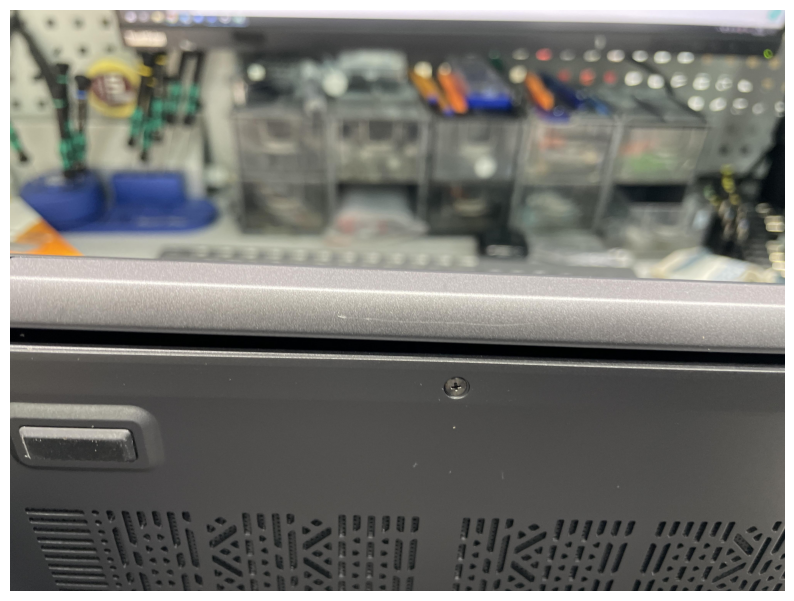

In [71]:
import cv2

model_load = YOLO('/kaggle/working/runs/detect/train6/weights/best.pt')

test_image_path = '/kaggle/input/sila-dataset/train/images/scratches/2024-01-15 16-27-01.jpg'  # вставляем картинку которую хотим проверить
image = cv2.imread(test_image_path)


results = model_load(test_image_path)

for result in results[0].boxes:  
    x1, y1, x2, y2 = result.xyxy[0].tolist()  # Координаты бокса
    confidence = result.conf[0].item()        # Уверенность
    class_id = int(result.cls[0].item())      # ID класса

    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # добавляем метку класса
    class_label = list(class_mapping.keys())[class_id]
    cv2.putText(image, f"{class_label} {confidence:.2f}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

output_path = '/kaggle/working/prediction_with_boxes.jpg'
cv2.imwrite(output_path, image)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Далее будет код для перевода меток класса которые задетектила ёла чтобы из детекции получить классификацию такой простой способ классификации через детекцию

# Ответ на вопрос для любопытных почему пришлось фиксить разметку - в изначальном датасете были перепутаны местами ширина и высота, а так же координата x левого нижнего угла а координата y левого верхнего если возьмете изначальный датасет и попробуете запустить код ниже то увидите что квадратик появляется не там где надо) но фикс весьма простой если понимать как работает геометрия
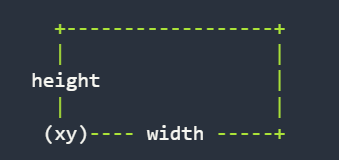

In [9]:
def display_image_with_bbox(row, image_dir):
    img_path = os.path.join(image_dir, row['filename'])
    img = cv2.imread(img_path)
    height, width, _ = img.shape
    
    x_lb = int(row['x_left_bottom'])
    y_lb = int(row['y_left_bottom'])
    length = int(row['length'])
    width_box =  int(row['width'])
    
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    
    rect = plt.Rectangle((x_lb, y_lb), width_box, length, linewidth=2, edgecolor='red', facecolor='none')
    plt.gca().add_patch(rect)

    plt.title(f"картинка {row['filename']}")
    plt.axis('off')
    plt.show()
    

4032 3024


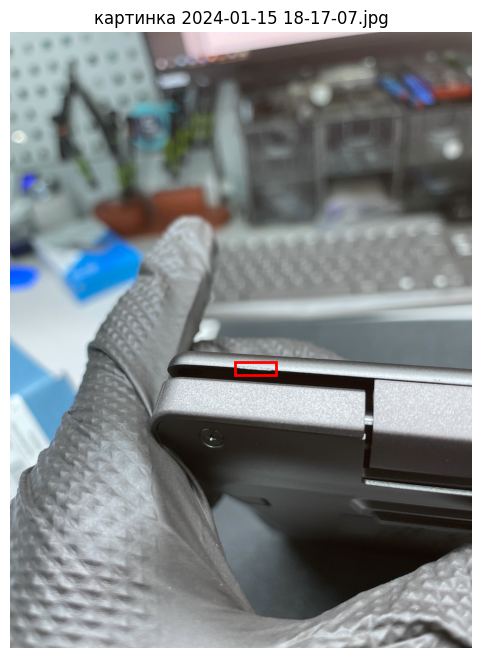

1893 2162


In [11]:
display_image_with_bbox(df.iloc[80], image_folder)